In [42]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import matplotlib.ticker as mtick

In [62]:
from pyxel.models import BrokenPow
from astropy.modeling.powerlaws import PowerLaw1D
from astropy.modeling.fitting import LevMarLSQFitter

Read the surface brightness profile from the text file. The profile is restricted to the radial range 100-330 arcmin (not much beyond 330 arcmin).

In [112]:
sb_file = "sb_n_07_2_100.txt"
with open(sb_file) as f:
    data = f.readlines()

rmin = 100.
rmax = 330.

# central radii of the bins
r = np.array([float(line.split()[0]) for line in data if rmin <= float(line.split()[0]) <= rmax])

# surface brightness 
sb = np.array([float(line.split()[1]) for line in data if rmin <= float(line.split()[0]) <= rmax])

# uncertainties on surface brightness
sb_err = np.array([float(line.split()[2]) for line in data if rmin <= float(line.split()[0]) <= rmax])

Plot the surface brightness profile to get an idea of what needs to be fitted to it.

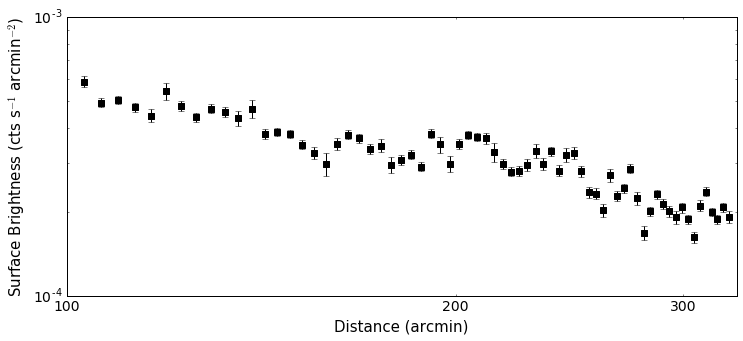

In [113]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.scatter(r, sb, s=30, marker='s', c="k")
plt.errorbar(r, sb, yerr=sb_err, linestyle="None", c="k")

plt.xlim(rmin, rmax)
plt.ylim(1e-4, 1e-3)
plt.loglog()

plt.xlabel('Distance (arcmin)', size=15)
plt.ylabel(r"Surface Brightness (cts s$^{-1}$ arcmin$^{-2}$)", size=15)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax.xaxis.set_minor_formatter(mtick.FormatStrFormatter('%.0f'))

Fit the profile with a broken power-law model. By default, jump is restricted to [1, 4], because values outside this range don't make sense for a shock.

In [114]:
model1 = BrokenPow(ind1=1., ind2=1., norm=6e-4, rbreak=200., jump=1.5, const=0.)
model1.const.fixed = True

fit1 = LevMarLSQFitter()
fitted_model1 = fit1(model1, r, sb, weights=1./sb_err, estimate_jacobian=True, maxiter=1000)
print(fitted_model1)

# No uncertainties are printed, because the best-fitting value of the jump reaches the lower boundary.
if fit1.fit_info['param_cov'] is not None:
    uncertainties = [np.sqrt(x) for x in fit1.fit_info['param_cov'].diagonal()]
    print('Parameter uncertainties (free params, if bounds not reached): \n', uncertainties)

Model: BrokenPow
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         ind1           ind2            norm           rbreak    jump const
    -------------- ------------- ----------------- ------------- ---- -----
    0.619952404381 1.12427020318 7.73402983345e-07 249.445991921  1.0   0.0


Plot the best-fitting broken power-law model.

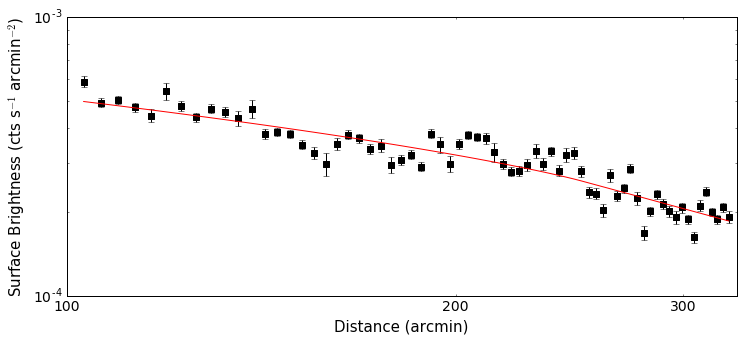

In [115]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.scatter(r, sb, s=30, marker='s', c="k")
plt.errorbar(r, sb, yerr=sb_err, linestyle="None", c="k")
plt.plot(r, fitted_model1(r), c='r')

plt.xlim(rmin, rmax)
plt.ylim(1e-4, 1e-3)
plt.loglog()

plt.xlabel('Distance (arcmin)', size=15)
plt.ylabel(r"Surface Brightness (cts s$^{-1}$ arcmin$^{-2}$)", size=15)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax.xaxis.set_minor_formatter(mtick.FormatStrFormatter('%.0f'))

Fit the profile with a simple power-law.

In [116]:
model2 = PowerLaw1D(amplitude=4e-4, x_0=100., alpha=2.)
model2.x_0.fixed = True

fit2 = LevMarLSQFitter()
fitted_model2 = fit2(model2, r, sb, weights=1./sb_err, estimate_jacobian=True, maxiter=2000)
print(fitted_model2, '\n')

if fit2.fit_info['param_cov'] is not None:
    uncertainties = [np.sqrt(x) for x in fit2.fit_info['param_cov'].diagonal()]
    print('Parameter uncertainties (free params, if bounds not reached): \n', uncertainties)

Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude      x_0      alpha     
    ----------------- ----- --------------
    0.000555126724764 100.0 0.872532488125 

Parameter uncertainties (free params, if bounds not reached): 
 [1.7209659422682028e-05, 0.039305708678248764]


Plot the best-fitting power-law.

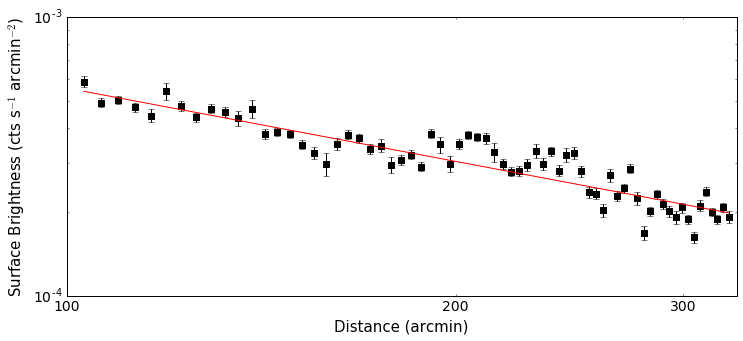

In [117]:
fig, ax = plt.subplots(figsize=(12, 5))
#plt.figure(figsize=(12, 5))
plt.scatter(r, sb, s=30, marker='s', c="k")
plt.errorbar(r, sb, yerr=sb_err, linestyle="None", c="k")
plt.plot(r, fitted_model2(r), c='r')

plt.xlim(rmin, rmax)
plt.ylim(1e-4, 1e-3)
plt.loglog()

plt.xlabel('Distance (arcmin)', size=15)
plt.ylabel(r"Surface Brightness (cts s$^{-1}$ arcmin$^{-2}$)", size=15)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax.xaxis.set_minor_formatter(mtick.FormatStrFormatter('%.0f'))